# Benchmark Computer Vision (CV) models using Amazon SageMaker Multi-model endpoints (MME) with GPU support

Amazon SageMaker multi-model endpoints with GPU works using NVIDIA Triton Inference Server. NVIDIA Triton Inference Server is open-source inference serving software that simplifies the inference serving process and provides high inference performance. Triton supports all major training and inference frameworks, such as TensorFlow, NVIDIA TensorRT, PyTorch, MXNet, Python, ONNX, XGBoost, scikit-learn, RandomForest, OpenVINO, custom C++, and more. It offers dynamic batching, concurrent execution, post-training quantization, optimal model configuration to achieve high performance inference.

In this notebook, we are going to run benchmark testing for the most popluar CV models using MME on GPU. We will evaluate model performance such as the inference latency, throughput, and optimum model count per instance. We will also compile these models using NVIDA TensorRT to compare performance against TorchScript models.

This notebook is tested on `PyTorch 1.12 Python 3.8 CPU Optimized` kernel on SageMaker Studio. An instance with at least 8 vCPU cores such as an `ml.c5.2xlarge` is recommended to run the load test. A smaller instance may be utilized by reducing the scale of the load test. The configuration provide here simulates up to 200 concurrent workers

**Here is a list of model we have tested, you can use this notebook to benchmark your own models:**

| Model Name      | Number of Parameters |
| -----------     | -------------------- | 
| resnet50        | 25M                  |
| convNeXt Base   | 88M                  |
| ViT Large       | 304M                 |
 

## Set up the environment

Installs the dependencies required to package the model and run inferences using Triton server.

Also define the IAM role that will give SageMaker access to the model artifacts and the NVIDIA Triton ECR image.

In [223]:
%pip install timm -Uqq
%pip install transformers -Uqq
%pip install locust -Uqq
%pip install boto3 -Uqq
%pip install sagemaker -Uqq
%pip install matplotlib -Uqq

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [224]:
import sagemaker
from sagemaker import get_execution_role
import torch
import torchvision.models as models
from pathlib import Path

import boto3
import json
from pathlib import Path
import time
import datetime as dt
import warnings

from utils.model_utils import get_model_from_timm, export_pt_jit, export_onnx, compile_trt, package_triton_model, count_parameters

role = get_execution_role()
sess = sagemaker.Session()

account = sess.account_id()
bucket = sess.default_bucket() # or use your own custom bucket name
prefix = 'mme-cv-benchmark'

use_case = "cv"

sm_client = boto3.client(service_name="sagemaker")
runtime_sm_client = boto3.client("sagemaker-runtime")

tested_models = ["resnet50", "vit_large_patch16_224", "convnext_base"]
model_name = "vit_large_patch16_224" #change the model name to benchmark different CV models

Account Id Mapping for triton inference containers

In [225]:
account_id_map = {
    'us-east-1': '785573368785',
    'us-east-2': '007439368137',
    'us-west-1': '710691900526',
    'us-west-2': '301217895009',
    'eu-west-1': '802834080501',
    'eu-west-2': '205493899709',
    'eu-west-3': '254080097072',
    'eu-north-1': '601324751636',
    'eu-south-1': '966458181534',
    'eu-central-1': '746233611703',
    'ap-east-1': '110948597952',
    'ap-south-1': '763008648453',
    'ap-northeast-1': '941853720454',
    'ap-northeast-2': '151534178276',
    'ap-southeast-1': '324986816169',
    'ap-southeast-2': '355873309152',
    'cn-northwest-1': '474822919863',
    'cn-north-1': '472730292857',
    'sa-east-1': '756306329178',
    'ca-central-1': '464438896020',
    'me-south-1': '836785723513',
    'af-south-1': '774647643957'
}

In [226]:
region = boto3.Session().region_name
if region not in account_id_map.keys():
    raise("UNSUPPORTED REGION")

## Generate Pretrained Models

We are going to use the following SageMaker Processing script to generate our pretrained model. This script does the following:

1. Generate a model using the [timm](#https://huggingface.co/docs/hub/timm) library

2. jit script the model and save the torchscript file

3. Create a model artifact which is comprised of the torchscript file and a model configuration (config.pbtxt) for Triton serving

Helper functions have been created for each of these steps and are imported from the `utils.model_utils` local module

In [227]:
if model_name in tested_models:
    model = get_model_from_timm(model_name)
    model.eval()
else:
    warnings.warn(f"{model_name} has not been tested and may not work")
    model = get_model_from_timm(model_name)
    model.eval()

print(f"loaded model {model_name} with {count_parameters(model)} parameters")

example_input = torch.randn(1, 3, 224, 224)

loaded model vit_large_patch16_224 with 304326632 parameters


## Packaging Pytorch model for Triton sever on SageMaker

**Note**: SageMaker expects the model tarball file to have a top level directory with the same name as the model defined in the `config.pbtxt`.

```
model_name
├── 1
│   └── model.pt
└── config.pbtxt
```

In [228]:
pytorch_model_path = Path(f"triton-serve-pt/{model_name}/1")
pytorch_model_path.mkdir(parents=True, exist_ok=True)
pt_model_path = export_pt_jit(model, example_input, pytorch_model_path) #export jit compiled model to specified directory

/opt/conda/lib/python3.7/site-packages/torch/__init__.py:853: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


<div class="alert alert-info"> <strong> Note: </strong>
The example config.pbtxt templates are configured for a model that accepts a single input of shape [3,224,224] and returns a single output with the shape [-1,1000]. This should work with most image classification models trained on imagenet-1k dataset but you may need to adjust the template if testing on other models
</div>

In [229]:
# We'll package a model config template along with the compiled model into a model.tar.gz artifact. 
# The config templates assume a 3x224x224 input with 1000 label output 
# You may need to adjust the template if not using one of the tested models
model_atifact_path = package_triton_model(model_name, pt_model_path, "model_config_templates/pt_cv_config.pbtxt")

In [230]:
mme_path = f"s3://{bucket}/{prefix}/{model_name}/"
initial_model_path = sess.upload_data(model_atifact_path.as_posix(), bucket=bucket, key_prefix=f"{prefix}{model_name}")

## Create a SageMaker Multi-Model Endpoint for PyTorch Model


In [231]:
from utils.endpoint_utils import create_endpoint, delete_endpoint, get_instance_utilization, run_load_test

base = "amazonaws.com.cn" if region.startswith("cn-") else "amazonaws.com"
mme_triton_image_uri = f"{account_id_map[region]}.dkr.ecr.{region}.{base}" + \
            "/sagemaker-tritonserver:22.10-py3"
print(mme_triton_image_uri)
instance_type = 'ml.g4dn.2xlarge'

301217895009.dkr.ecr.us-west-2.amazonaws.com/sagemaker-tritonserver:22.10-py3


In [232]:
container = {
    "Image": mme_triton_image_uri,
    "ModelDataUrl": mme_path,
    "Mode": "MultiModel"
}

We'll deploy and endpoint is deployed using a helper function

In [233]:
sm_model_name, endpoint_config_name, endpoint_name = create_endpoint(sm_client, model_name, role, container, instance_type, "pt")

Model Arn: arn:aws:sagemaker:us-west-2:376678947624:model/vit-large-patch16-224-pt-gpu-2022-12-28-01-26-27
Endpoint Config Arn: arn:aws:sagemaker:us-west-2:376678947624:endpoint-config/vit-large-patch16-224-pt-gpu-2022-12-28-01-26-28
Endpoint Arn: arn:aws:sagemaker:us-west-2:376678947624:endpoint/vit-large-patch16-224-pt-gpu-2022-12-28-01-26-28
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-west-2:376678947624:endpoint/vit-large-patch16-224-pt-gpu-2022-12-28-01-26-28
Status: InService


Next we'll upload a python model that we can use to query the instance utilization in real time

In [234]:
!tar czvf metrics.tar.gz server_metrics/
!aws s3 cp metrics.tar.gz {mme_path}

server_metrics/
server_metrics/config.pbtxt
server_metrics/1/
server_metrics/1/model.py
upload: ./metrics.tar.gz to s3://sagemaker-us-west-2-376678947624/mme-cv-benchmark/vit_large_patch16_224/metrics.tar.gz


In [235]:
get_instance_utilization(runtime_sm_client, endpoint_name) #invoke once to load the python model in memory

{'gpu_utilization': 0.0,
 'gpu_memory_utilization': 0.010920643325170428,
 'gpu_total_memory': 15109.0,
 'gpu_free_memory': 14944.0,
 'gpu_used_memory': 165.0,
 'cpu_utilization': 0.800000011920929,
 'memory_utilization': 0.03999999910593033}

## Load PyTorch Models into Endpoint

In this section we will determine the maximum number of model copies that the endpoint can load into memory within a specified threshold
- When a model is invoked for the first time, SageMaker will load it into the GPU Memory
- In this section we will invoke the model with a sample endpoint which result in it being loaded into memory
- We'll then make copies of the model on S3 and invoke each copy until we reach the specified GPU Memory threshold which we set at 90% of Available memory 

In [236]:
import json
import numpy as np
import random

payload = {
    "inputs": [
        {
            "name": "INPUT__0",
            "shape": [1, 3, 224, 224],
            "datatype": "FP32",
            "data": np.random.rand(3, 224,224).tolist(),
        }
    ]
}

In [237]:
models_loaded = 0
memory_utilization_threshold = 0.9
memory_utilization_history = []
while True:
    # make a copy of the model
    !aws s3 cp {initial_model_path} {mme_path}{model_name}-v{models_loaded}.tar.gz
    
    # make a inference request to load model into memory
    response = runtime_sm_client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="application/octet-stream",
            Body=json.dumps(payload),
            TargetModel=f"{model_name}-v{models_loaded}.tar.gz", 
        )
    
    models_loaded+=1
    
    #get instance metrics
    instance_metrics = get_instance_utilization(runtime_sm_client, endpoint_name)
    model_avg_mem_consumption = instance_metrics["gpu_used_memory"] / models_loaded
    
    # get an estimate of the gpu memory util once next model is loaded
    next_gpu_mem_util = (instance_metrics["gpu_used_memory"] + model_avg_mem_consumption) / instance_metrics["gpu_total_memory"]
    
    memory_utilization = instance_metrics["gpu_memory_utilization"]
    memory_utilization_history.append(memory_utilization)
    
    # terminate loop if the memory consumption is exceeded once next model is loaded
    if next_gpu_mem_util >= memory_utilization_threshold:
        print(f"This instance is able to load {models_loaded} models with {memory_utilization:.2%} of gpu memory consumed")
        break
        
    print(f"loaded {models_loaded} models with memory utilzation of {memory_utilization:.2%}")

copy: s3://sagemaker-us-west-2-376678947624/mme-cv-benchmarkvit_large_patch16_224/vit_large_patch16_224.tar.gz to s3://sagemaker-us-west-2-376678947624/mme-cv-benchmark/vit_large_patch16_224/vit_large_patch16_224-v0.tar.gz
loaded 1 models with memory utilzation of 14.20%
copy: s3://sagemaker-us-west-2-376678947624/mme-cv-benchmarkvit_large_patch16_224/vit_large_patch16_224.tar.gz to s3://sagemaker-us-west-2-376678947624/mme-cv-benchmark/vit_large_patch16_224/vit_large_patch16_224-v1.tar.gz
loaded 2 models with memory utilzation of 22.17%
copy: s3://sagemaker-us-west-2-376678947624/mme-cv-benchmarkvit_large_patch16_224/vit_large_patch16_224.tar.gz to s3://sagemaker-us-west-2-376678947624/mme-cv-benchmark/vit_large_patch16_224/vit_large_patch16_224-v2.tar.gz
loaded 3 models with memory utilzation of 30.13%
copy: s3://sagemaker-us-west-2-376678947624/mme-cv-benchmarkvit_large_patch16_224/vit_large_patch16_224.tar.gz to s3://sagemaker-us-west-2-376678947624/mme-cv-benchmark/vit_large_patch

## Benchmark Pytorch Model using Locust

`locust_benchmark_sm.py` is provided in the 'locust' folder

<div class="alert alert-info"> <strong> Note: </strong>
The load test is run with up to 200 simulated workers. This may not be suitable for larger models with long response times. You can modify the <code>StagesShape</code> Class in the <code>locust/locust_benchmark_sm.py</code> file to adjust the traffic pattern and the number of concurrent workers
</div>

In [238]:
locust_result_path = Path("results") / model_name
locust_result_path.mkdir(parents=True,exist_ok=True)

In [239]:
%%time
output_path = (locust_result_path / f"{instance_type}*pt*{models_loaded}") # capture the instance type, engine, and models loaded in file name
run_load_test(endpoint_name, use_case, model_name, models_loaded, output_path, print_stdout=False, n_procs=6)

running load test
OrderedDict([('Type', 'InvokeEndpoint'), ('Name', 'vit_large_patch16_224'), ('Request Count', '208'), ('Failure Count', '0'), ('Median Response Time', '380.0'), ('Average Response Time', '500.40060058659736'), ('Min Response Time', '251.83132399979513'), ('Max Response Time', '2769.4230179986334'), ('Average Content Size', '0.0'), ('Requests/s', '12.0130740833096'), ('Failures/s', '0.0'), ('50%', '380'), ('66%', '460'), ('75%', '490'), ('80%', '520'), ('90%', '630'), ('95%', '1100'), ('98%', '2600'), ('99%', '2600'), ('99.9%', '2800'), ('99.99%', '2800'), ('100%', '2800')])
OrderedDict([('Type', 'InvokeEndpoint'), ('Name', 'vit_large_patch16_224'), ('Request Count', '634'), ('Failure Count', '0'), ('Median Response Time', '450.0'), ('Average Response Time', '599.2329072145977'), ('Min Response Time', '251.83132399979513'), ('Max Response Time', '2855.1073579983495'), ('Average Content Size', '0.0'), ('Requests/s', '13.349890520845284'), ('Failures/s', '0.0'), ('50%', 

PosixPath('results/vit_large_patch16_224/ml.g4dn.2xlarge*pt*10')

In [240]:
# import some utilities to analyze the results of the load test
from utils.viz_utils import get_summary_results, generate_summary_plots, generate_metrics_summary

In [241]:
%matplotlib inline

In [242]:
load_test_summary = get_summary_results(locust_result_path)

defaultdict(dict,
            {'vit_large_patch16_224': {'ml.g4dn.2xlarge*pt': <Figure size 1000x600 with 3 Axes>}})

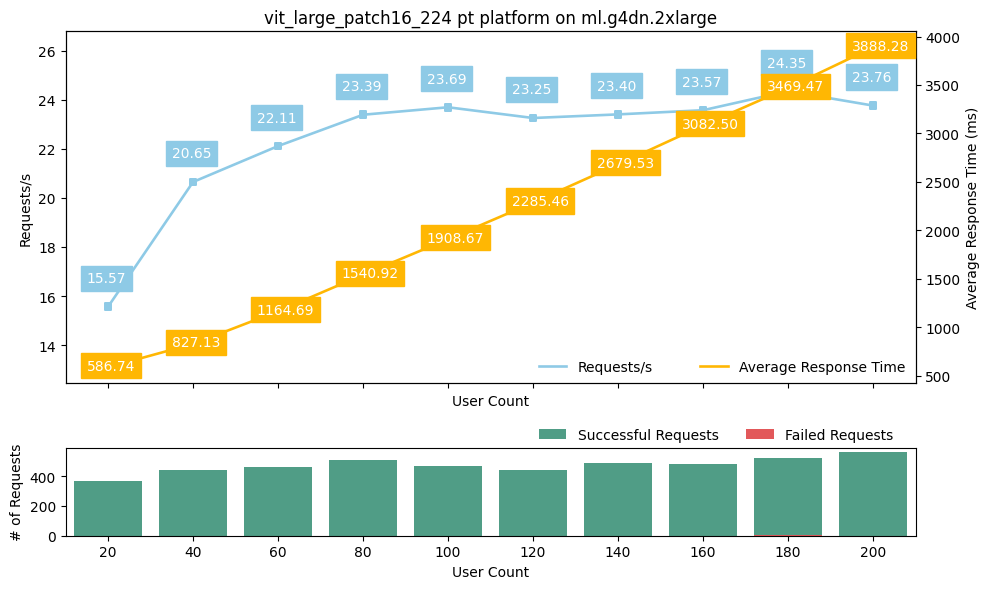

In [243]:
generate_summary_plots(load_test_summary)

## Clean Up PyTorch Endpoint

In [244]:
delete_endpoint(sm_client, sm_model_name, endpoint_config_name, endpoint_name)
! aws s3 rm --recursive {mme_path}

delete: s3://sagemaker-us-west-2-376678947624/mme-cv-benchmark/vit_large_patch16_224/metrics.tar.gz
delete: s3://sagemaker-us-west-2-376678947624/mme-cv-benchmark/vit_large_patch16_224/vit_large_patch16_224-v0.tar.gz
delete: s3://sagemaker-us-west-2-376678947624/mme-cv-benchmark/vit_large_patch16_224/vit_large_patch16_224-v3.tar.gz
delete: s3://sagemaker-us-west-2-376678947624/mme-cv-benchmark/vit_large_patch16_224/vit_large_patch16_224-v1.tar.gz
delete: s3://sagemaker-us-west-2-376678947624/mme-cv-benchmark/vit_large_patch16_224/vit_large_patch16_224-v7.tar.gz
delete: s3://sagemaker-us-west-2-376678947624/mme-cv-benchmark/vit_large_patch16_224/vit_large_patch16_224-v8.tar.gz
delete: s3://sagemaker-us-west-2-376678947624/mme-cv-benchmark/vit_large_patch16_224/vit_large_patch16_224-v4.tar.gz
delete: s3://sagemaker-us-west-2-376678947624/mme-cv-benchmark/vit_large_patch16_224/vit_large_patch16_224-v6.tar.gz
delete: s3://sagemaker-us-west-2-376678947624/mme-cv-benchmark/vit_large_patch16_

## Benchmark a TensorRT model
Next we'll convert the PyTorch model to a TensorRT model with the following steps

1. Convert the model to ONNX. ONNX is intemediate file format which is framework agnostic. It works with models in TF, PyTorch and more.

2. Spin up a SageMaker processing job to convert ONNX model to a TensorRT model plan. You will export the weights of your model from the framework and load them into your TensorRT network.

<div class="alert-danger" role="alert"> <strong> Warning: </strong>
For TensorRT models, The hosting instance type must match the instance type the model is compiled on. To help ensure compatability, we'll compile the model using a SageMaker Processing job. Note that this will incur an additional cost of running the job. Also, SageMaker Processing doescurrently support ml.g5 family of instances, so these compiled models will only run on the ml.g4dn family of instances. To deploy on an ml.g5 instance, please compile the model on an EC2 or a SageMaker notebook instance 
</div>

### <span style="color:red"> </span>

In [245]:
onnx_path = Path("onnx-models")
onnx_path.mkdir(exist_ok=True)

In [246]:
onnx_model_path = Path(f"onnx-models/{model_name}")
onnx_model_path.mkdir(exist_ok=True)
exported_onnx_path = export_onnx(model=model, sample_input=example_input, save_path=onnx_model_path)

/opt/conda/lib/python3.7/site-packages/torch/__init__.py:853: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


In [247]:
## Supply command line arguments to the trtexec command line utility
trt_compilation_args = [
                        "--explicitBatch", 
                        "--minShapes=INPUT__0:1x3x224x224",
                        "--optShapes=INPUT__0:64x3x224x224",
                        "--maxShapes=INPUT__0:128x3x224x224",
                        "--fp16",
                        "--verbose"
                        ]

In [ ]:
# This command could take some time to run. Up to 30 min for the models tested
trt_model_path = compile_trt(onnx_model_path=exported_onnx_path, 
                             sagemaker_session=sess, 
                             bucket=bucket,
                             prefix=prefix,
                             role=role,
                             image_uri=mme_triton_image_uri, 
                             instance_type=instance_type, 
                             trt_compilation_args=trt_compilation_args)

Waiting for training job trt-compilation2022-12-28-01-40-47 to complete

2022-12-28 01:40:52 Starting - Starting the training job...
2022-12-28 01:41:09 Starting - Preparing the instances for training.............
2022-12-28 01:42:21 Downloading - Downloading input data......
2022-12-28 01:42:56 Training - Downloading the training image....................
2022-12-28 01:44:42 Training - Training image download completed. Training in progress.................................................................................................................................................................................................................................................................................................................................................................................................

Package TensorRT model for Triton sever on SageMaker

In [ ]:
trt_model_atifact_path = package_triton_model(model_name, trt_model_path, "model_config_templates/trt_cv_config.pbtxt")

In [ ]:
initial_trt_model_path = sess.upload_data(trt_model_atifact_path.as_posix(), bucket=bucket, key_prefix=prefix) 
trt_mme_path = f"s3://{bucket}/{prefix}/trt-{model_name}/"

## Create a SageMaker Multi-Model Endpoint for TensorRT Model

In [ ]:
trt_container = {
    "Image": mme_triton_image_uri,
    "ModelDataUrl": trt_mme_path,
    "Mode": "MultiModel",
}

In [ ]:
sm_model_name, endpoint_config_name, endpoint_name = create_endpoint(sm_client, model_name, role, trt_container, instance_type, "trt")

Copy the Python model to query the instance metrics

In [ ]:
!aws s3 cp metrics.tar.gz {trt_mme_path}

In [ ]:
get_instance_utilization(runtime_sm_client, endpoint_name) #invoke once to load the python model in memory

## Load TensorRT Models into Endpoint
We'll repeat the same procedure to determine the max number of TensorRT models that we can load in memory

In [ ]:
models_loaded = 0
memory_utilization_threshold = 0.9
memory_utilization_history = []
while True:
    # make a copy of the model
    !aws s3 cp {initial_trt_model_path} {trt_mme_path}{model_name}-v{models_loaded}.tar.gz
    
    # make a inference request to load model into memory
    response = runtime_sm_client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="application/octet-stream",
            Body=json.dumps(payload),
            TargetModel=f"{model_name}-v{models_loaded}.tar.gz", 
        )
    
    models_loaded+=1
    
    #get instance metrics
    instance_metrics = get_instance_utilization(runtime_sm_client, endpoint_name)
    model_avg_mem_consumption = instance_metrics["gpu_used_memory"] / models_loaded
    
    # get an estimate of the gpu memory util once next model is loaded
    next_gpu_mem_util = (instance_metrics["gpu_used_memory"] + model_avg_mem_consumption) / instance_metrics["gpu_total_memory"]
    
    memory_utilization = instance_metrics["gpu_memory_utilization"]
    memory_utilization_history.append(memory_utilization)
    
    # terminate loop if the memory consumption is exceeded once next model is loaded
    if next_gpu_mem_util >= memory_utilization_threshold:
        print(f"This instance is able to load {models_loaded} models with {memory_utilization:.2%} of gpu memory consumed")
        break
        
    print(f"loaded {models_loaded} models with memory utilzation of {memory_utilization:.2%}")

## Benchmark TensorRT Model using Locust

In [ ]:
locust_result_path = Path("results") / model_name
locust_result_path.mkdir(parents=True,exist_ok=True)

In [ ]:
%%time
output_path = (locust_result_path / f"{instance_type}*trt*{models_loaded}") # capture the instance type, engine, and models loaded in file name
run_load_test(endpoint_name, use_case, model_name, models_loaded, output_path, print_stdout=False, n_procs=6)

## Analyze Results

In [ ]:
load_test_summary = get_summary_results(locust_result_path)

In [ ]:
load_test_summary

In [ ]:
generate_summary_plots(load_test_summary)

In [ ]:
summary_chart = generate_metrics_summary(load_test_summary, instance_type)

## Clean Up TensorRT Endpoint

In [ ]:
delete_endpoint(sm_client, sm_model_name, endpoint_config_name, endpoint_name)
! aws s3 rm --recursive {trt_mme_path}